# Multidimensional Regression on LHC collision jets Submission

Add your solution below!

To run the notebook in VS Code, you can click on the `Run All` button in the toolbar. You may need to select the kernel to run. When prompted select `Python Environments` and then `.venv` (Should be starred).

> Note: You can add dependencies to your virtual environment by running `aqora add <dependency name>` or editing the `pyproject.toml` at the root of the project

Once you're ready, you can open a terminal by clicking `Terminal` and then `New Terminal` in the context bar at the very top. To test your solution, run

```bash
aqora test
```

Finally, once all the tests are passing, to submit to **Aqora** run

```bash
aqora upload
```


In [3]:
import h5py

f = h5py.File("/Users/majortimberwolf/Projects/cern-2025-challenge-2/.aqora/data/data/pp-z-to-jets-500K-57246.h5", "r")
n_events = 100 # find out number of events from partons

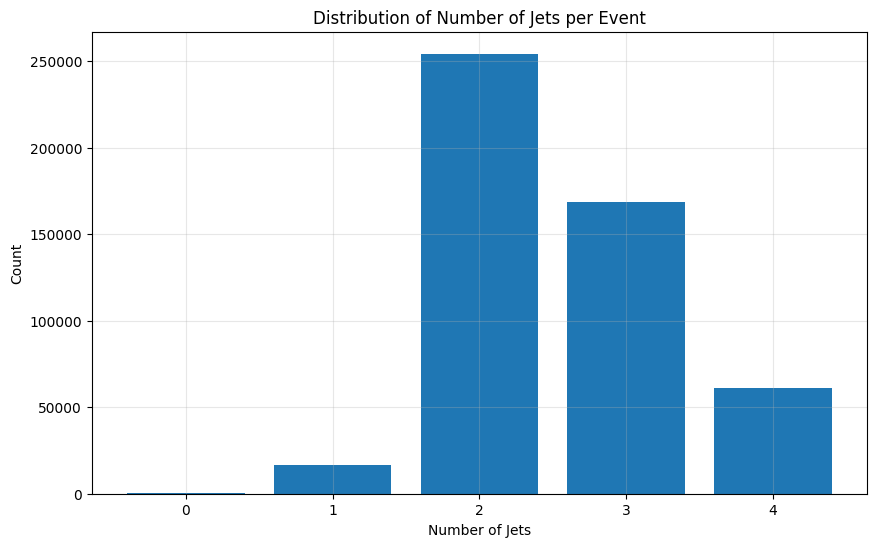

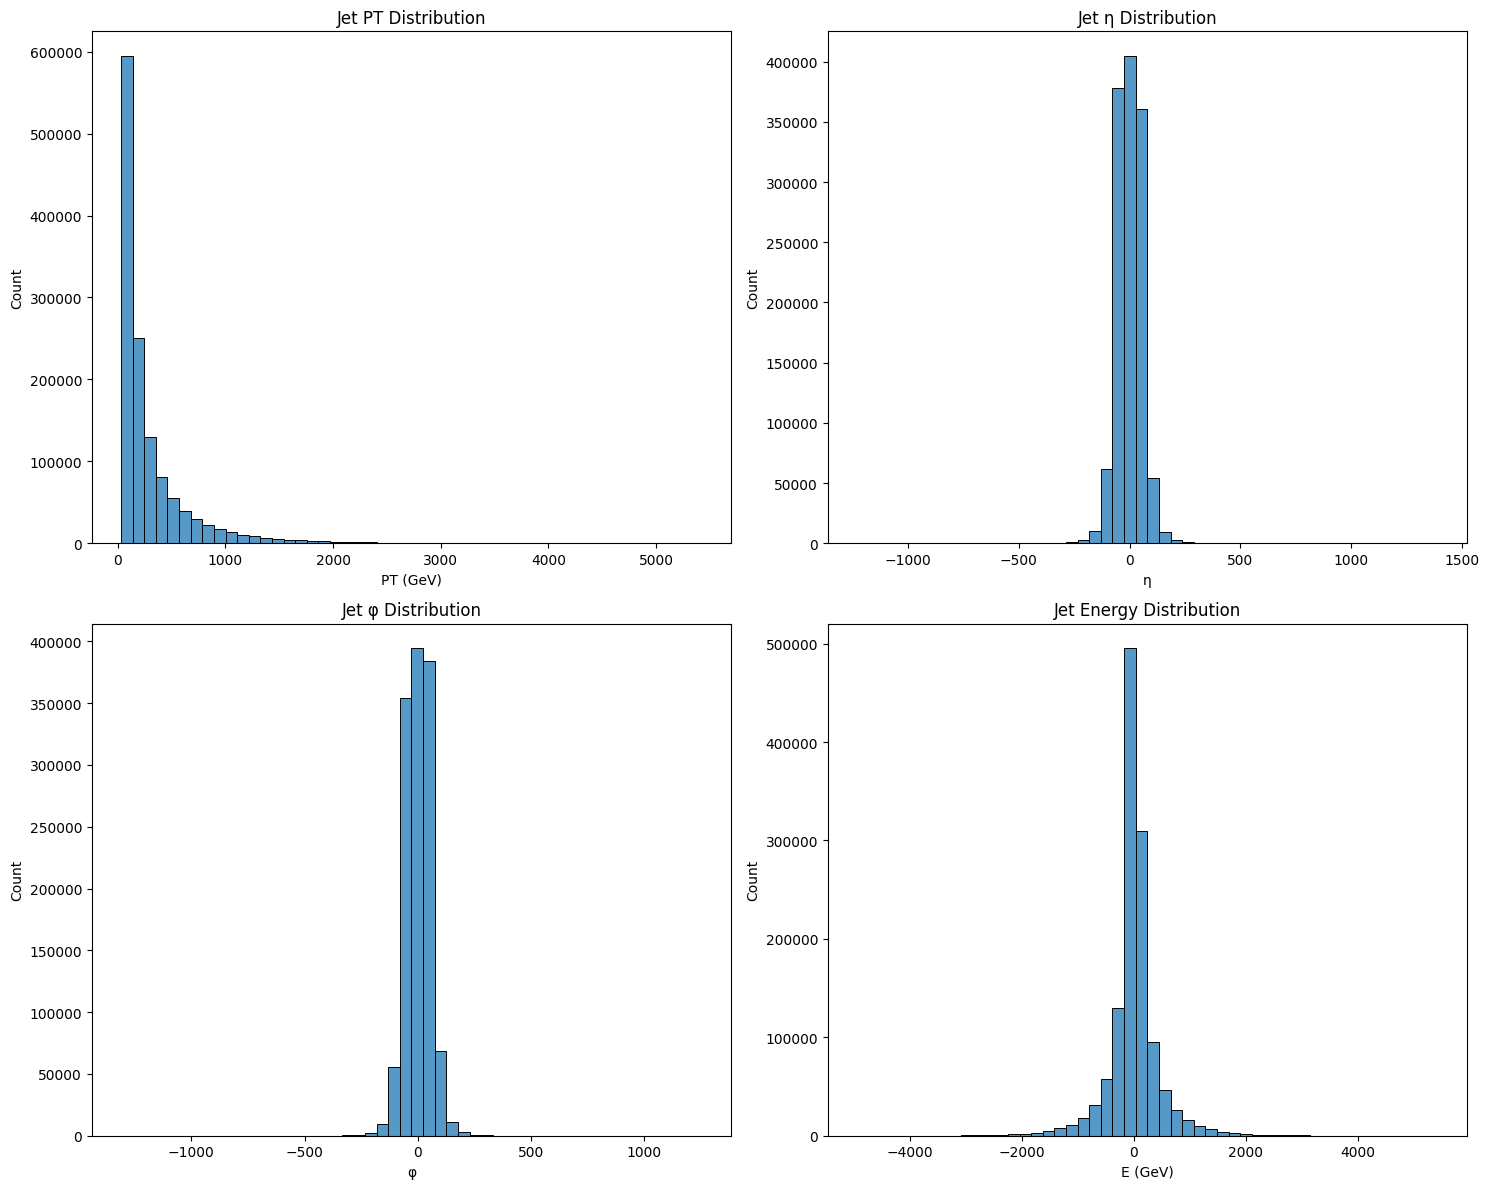

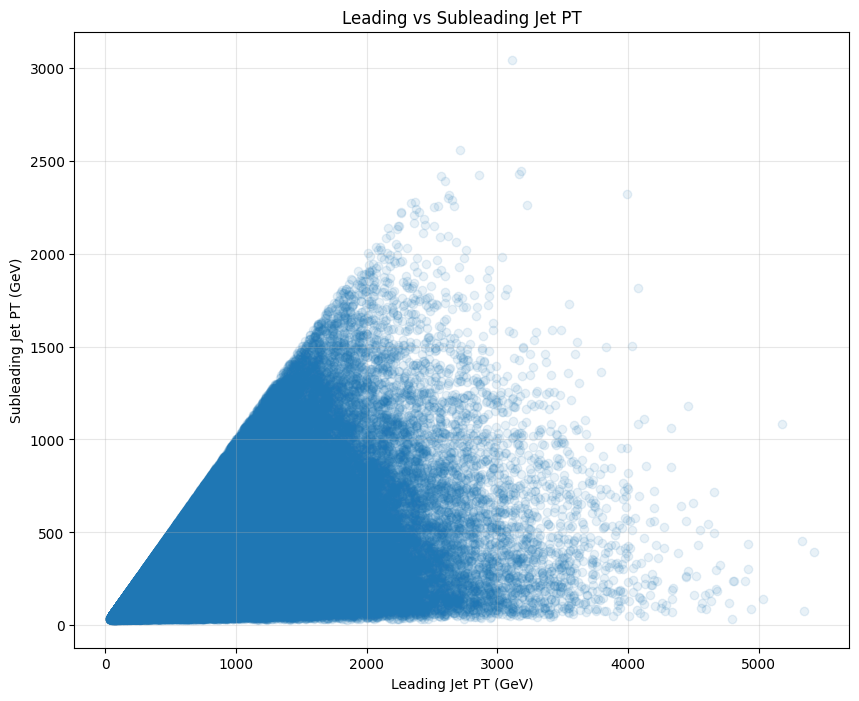


Jet Statistics:
                 pt           eta           phi             E
count  1.287056e+06  1.287056e+06  1.287056e+06  1.287056e+06
mean   2.906856e+02 -1.478677e-02 -1.094619e-02 -4.448770e-01
std    3.626822e+02  5.523516e+01  5.527778e+01  4.580813e+02
min    3.012549e+01 -1.232427e+03 -1.310349e+03 -4.942762e+03
25%    8.216029e+01 -3.773592e+01 -3.774093e+01 -1.297850e+02
50%    1.526647e+02  8.690228e-03 -1.719512e-02 -1.051148e-01
75%    3.429771e+02  3.771512e+01  3.767818e+01  1.289876e+02
max    5.425617e+03  1.392738e+03  1.254059e+03  5.424682e+03


In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from vector import Vector  # For handling 4-vectors

# Load the data
with h5py.File('/Users/majortimberwolf/Projects/cern-2025-challenge-2/.aqora/data/data/pp-z-to-jets-500K-57246.h5', 'r') as f:
    partons = f['partons'][:]  # Contains px, py, pz, E, particle_id, charge
    jets = f['jets'][:]        # Contains pt, eta, phi, E components

# 1. First, let's analyze number of jets per event
def count_nonzero_jets(jets_array):
    return np.count_nonzero(np.any(jets_array != 0, axis=2), axis=1)

n_jets_per_event = count_nonzero_jets(jets)

plt.figure(figsize=(10, 6))
plt.hist(n_jets_per_event, bins=range(6), align='left', rwidth=0.8)
plt.title('Distribution of Number of Jets per Event')
plt.xlabel('Number of Jets')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Analyze jet properties directly without Vector class
def get_jet_properties(jets_array):
    properties = []
    for event in jets_array:
        for jet in event:
            if not np.all(jet == 0):  # Skip zero-padded jets
                properties.append({
                    'pt': jet[0],    # PT is directly available
                    'eta': jet[1],   # eta is directly available
                    'phi': jet[2],   # phi is directly available
                    'E': jet[3]      # energy is directly available
                })
    return pd.DataFrame(properties)

jet_properties = get_jet_properties(jets)

# Create visualization of jet properties
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# PT distribution
sns.histplot(data=jet_properties, x='pt', bins=50, ax=axes[0,0])
axes[0,0].set_title('Jet PT Distribution')
axes[0,0].set_xlabel('PT (GeV)')

# Eta distribution
sns.histplot(data=jet_properties, x='eta', bins=50, ax=axes[0,1])
axes[0,1].set_title('Jet η Distribution')
axes[0,1].set_xlabel('η')

# Phi distribution
sns.histplot(data=jet_properties, x='phi', bins=50, ax=axes[1,0])
axes[1,0].set_title('Jet φ Distribution')
axes[1,0].set_xlabel('φ')

# Energy distribution
sns.histplot(data=jet_properties, x='E', bins=50, ax=axes[1,1])
axes[1,1].set_title('Jet Energy Distribution')
axes[1,1].set_xlabel('E (GeV)')

plt.tight_layout()
plt.show()

# 3. Leading vs subleading jet PT
def get_leading_jets_pt(jets_array):
    leading_pts = []
    subleading_pts = []
    
    for event in jets_array:
        pts = [jet[0] for jet in event if not np.all(jet == 0)]  # jet[0] is PT
        if len(pts) >= 2:
            pts.sort(reverse=True)
            leading_pts.append(pts[0])
            subleading_pts.append(pts[1])
            
    return leading_pts, subleading_pts

leading_pts, subleading_pts = get_leading_jets_pt(jets)

plt.figure(figsize=(10, 8))
plt.scatter(leading_pts, subleading_pts, alpha=0.1)
plt.xlabel('Leading Jet PT (GeV)')
plt.ylabel('Subleading Jet PT (GeV)')
plt.title('Leading vs Subleading Jet PT')
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
print("\nJet Statistics:")
print(jet_properties.describe())

In [ ]:
import numpy as np
import pandas as pd

rng = np.random.default_rng()

solution = pd.DataFrame({
    "EventID": np.arange(0, n_events),
    "n_jets_pred": rng.integers(low=0, high=10, size=n_events),
    "leading_pt_pred": rng.uniform(low=30, high=130, size=n_events),
    "subleading_pt_pred": rng.uniform(low=30, high=130, size=n_events),
})

In [ ]:
import io

output = io.StringIO()
solution.to_csv(output)
output = output.getvalue()